### LSTM 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os

`DATA PREPROCESSING`

In [2]:
data =  pd.read_csv('AAPL.csv', header=0)

In [3]:
data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2018-11-12 00:00:00+00:00,194.17,199.85,193.79,199.00,51135518,46.650144,48.014787,46.558847,47.810571,204542072,0.0,1.0
1,AAPL,2018-11-13 00:00:00+00:00,192.23,197.18,191.45,191.63,46882936,46.184051,47.373309,45.996653,46.039898,187531744,0.0,1.0
2,AAPL,2018-11-14 00:00:00+00:00,186.80,194.48,185.93,193.90,60800957,44.879471,46.724623,44.670450,46.585275,243203828,0.0,1.0
3,AAPL,2018-11-15 00:00:00+00:00,191.41,191.97,186.90,188.39,46478801,45.987043,46.121585,44.903496,45.261475,185915204,0.0,1.0
4,AAPL,2018-11-16 00:00:00+00:00,193.53,194.97,189.46,190.50,36928253,46.496381,46.842347,45.518547,45.768411,147713012,0.0,1.0


In [4]:
print(data.columns)
print(data.shape)

Index(['symbol', 'date', 'close', 'high', 'low', 'open', 'volume', 'adjClose',
       'adjHigh', 'adjLow', 'adjOpen', 'adjVolume', 'divCash', 'splitFactor'],
      dtype='object')
(1256, 14)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


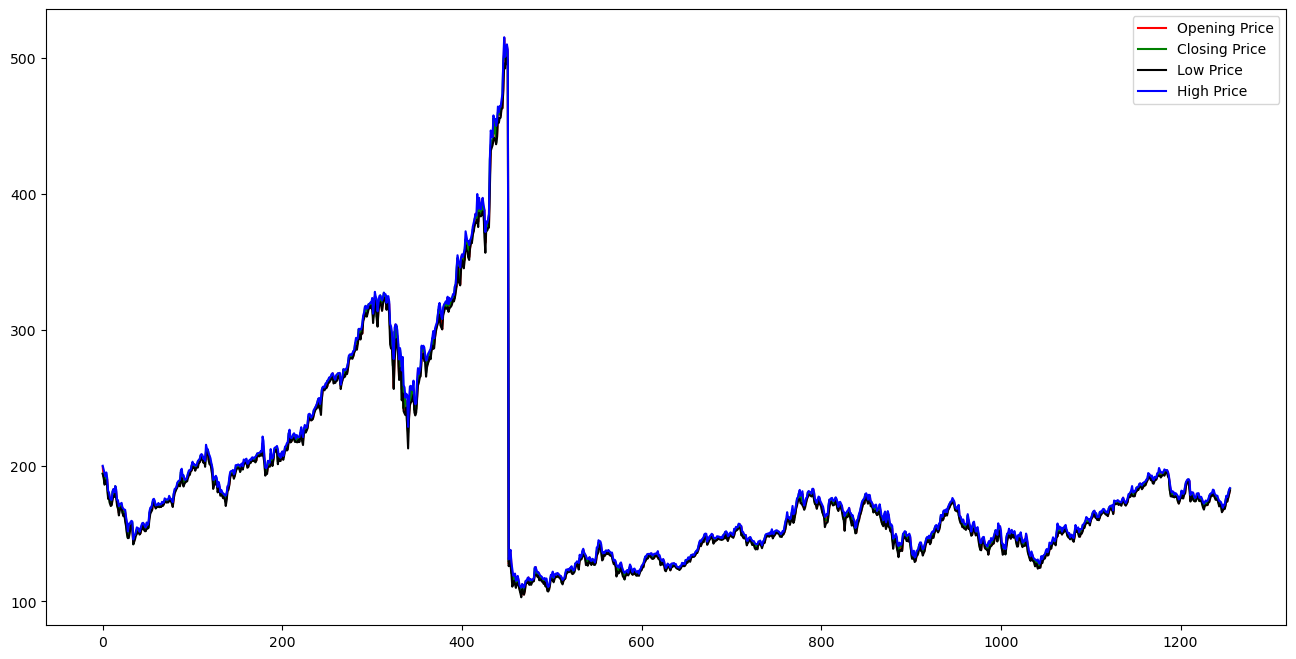

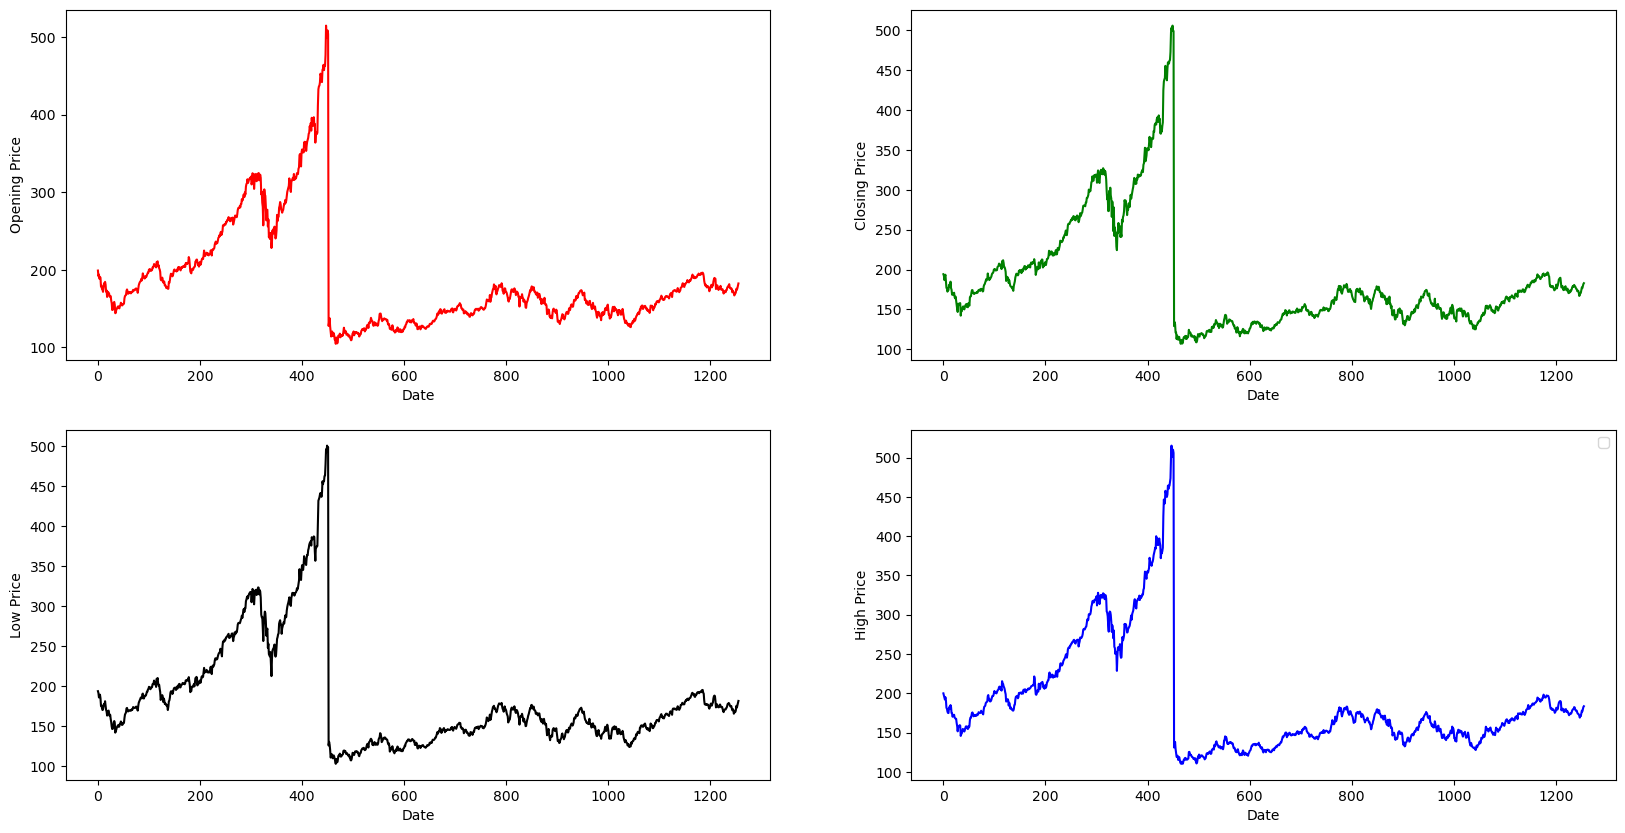

In [6]:
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(data['open'], color='red', label = 'Opening Price')
plt.plot(data['close'], color='green', label = 'Closing Price')
plt.plot(data['low'], color='black', label = 'Low Price')
plt.plot(data['high'], color='blue', label = 'High Price')
plt.legend(loc='best')

plt.subplots(2, 2, figsize = (20, 10))

ax1 = plt.subplot(2, 2, 1)
plt.plot(data['open'], color='red')
plt.xlabel('Date')
plt.ylabel('Opening Price')

ax2 = plt.subplot(2, 2, 2)
plt.plot(data['close'], color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price')

ax3 = plt.subplot(2, 2, 3)
plt.plot(data['low'], color='black')
plt.xlabel('Date')
plt.ylabel('Low Price')

ax4 = plt.subplot(2, 2, 4)
plt.plot(data['high'], color='blue')
plt.xlabel('Date')
plt.ylabel('High Price')

plt.legend()


In [7]:
data_prices = data.drop(['close', 'low', 'high'], axis=1)

In [13]:
data_training = pd.DataFrame(data['close'][0:int(len(data) *0.70)])
data_testing = pd.DataFrame(data['close'][int(len(data)*0.70): int(len(data))])

In [17]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler (feature_range=(0,1))
data_prices_scaled = scaler.fit_transform(data_training)
data_prices_scaled


array([[2.18735128e-01],
       [2.13876018e-01],
       [2.00275517e-01],
       [2.11822167e-01],
       [2.17132123e-01],
       [1.97921102e-01],
       [1.75679399e-01],
       [1.75178460e-01],
       [1.63932373e-01],
       [1.69768316e-01],
       [1.68816531e-01],
       [1.85597996e-01],
       [1.82116468e-01],
       [1.79686913e-01],
       [1.95316218e-01],
       [1.74953037e-01],
       [1.70018785e-01],
       [1.54414527e-01],
       [1.57194740e-01],
       [1.54765185e-01],
       [1.55942392e-01],
       [1.60576080e-01],
       [1.46875391e-01],
       [1.43018159e-01],
       [1.48353162e-01],
       [1.35378835e-01],
       [1.25209768e-01],
       [1.09931121e-01],
       [1.00162805e-01],
       [1.26061365e-01],
       [1.23506575e-01],
       [1.23706951e-01],
       [1.27489042e-01],
       [1.27939887e-01],
       [8.85410144e-02],
       [1.03744521e-01],
       [1.02917971e-01],
       [1.09981215e-01],
       [1.16393237e-01],
       [1.17620539e-01],


In [18]:
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]                                             
    
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [19]:
X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_prices_scaled, n_future=1, n_past=25, train_test_split_percentage=0.8,
                                               validation_split_percentage = 0)

In [20]:
data_prices_scaled.shape


(879, 1)

In [21]:
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]                                             
    
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [22]:
X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_prices_scaled, n_future=1, n_past=25, train_test_split_percentage=0.8,
                                               validation_split_percentage = 0)

In [23]:
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

2023-11-09 20:51:11.057672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-09 20:51:11.063680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-09 20:51:11.065579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 25, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40


2023-11-09 20:51:21.269319: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-09 20:51:21.511546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-09 20:51:21.513103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-09 20:51:21.514780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

5/8 [=================>............] - ETA: 0s - loss: 0.1003 - root_mean_squared_error: 0.3166 

2023-11-09 20:51:23.849484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-09 20:51:23.850636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-09 20:51:23.851586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 3s 98ms/step - loss: 0.0862 - root_mean_squared_error: 0.2937 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0622
Epoch 2/40
8/8 [==============================] - 0s 17ms/step - loss: 0.0274 - root_mean_squared_error: 0.1654 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1548
Epoch 3/40
8/8 [==============================] - 0s 17ms/step - loss: 0.0285 - root_mean_squared_error: 0.1688 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1051
Epoch 4/40
8/8 [==============================] - 0s 17ms/step - loss: 0.0209 - root_mean_squared_error: 0.1446 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0691
Epoch 5/40
8/8 [==============================] - 0s 17ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0703
Epoch 6/40
8/8 [==============================] - 0s 17ms/step - loss: 0.0186 - root_mean_squared_error: 0.1364 - val_loss: 0.0053 - val_root_mean_squared_error: 0.07

In [25]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

`LOSS CURVE AND PERFORMANCE METRICS`

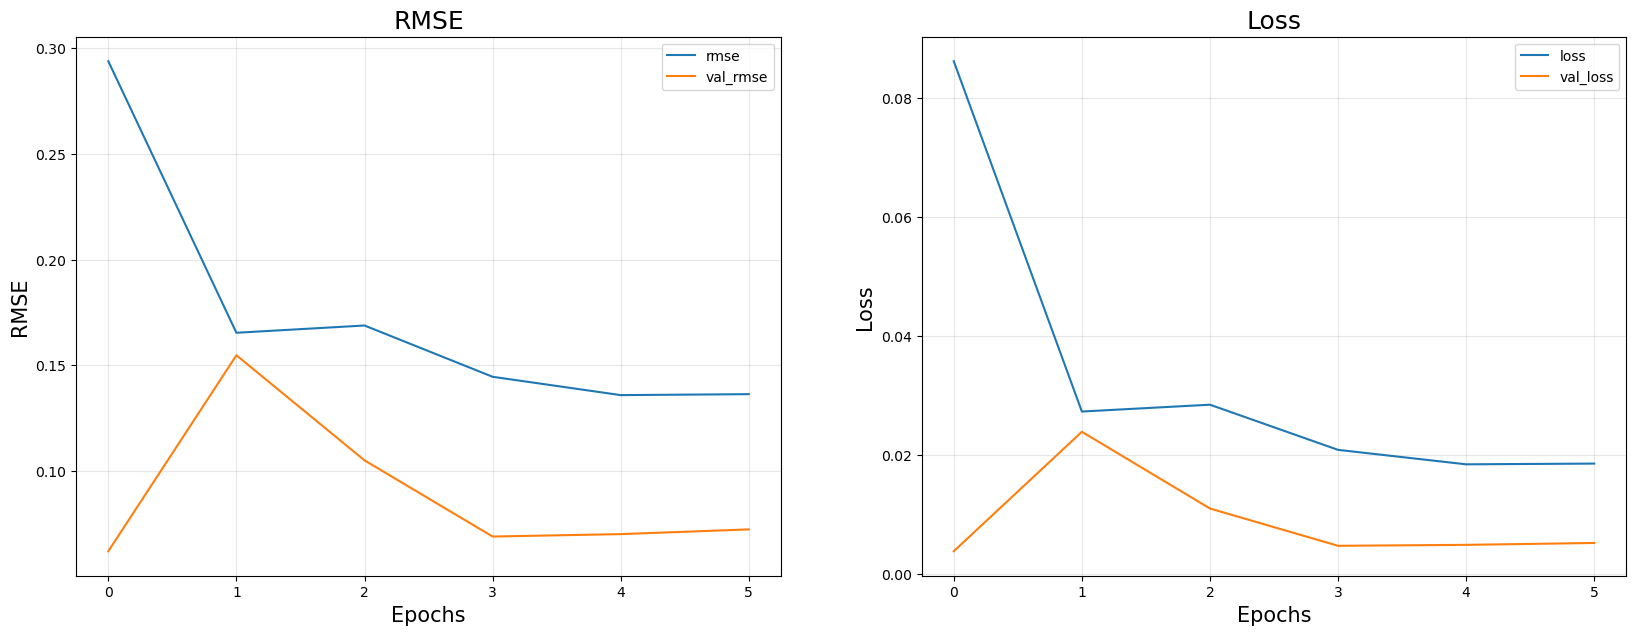

In [27]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [28]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

6/6 [==============================] - 0s 3ms/step - loss: 0.0037 - root_mean_squared_error: 0.0607
test loss, test acc: [0.0037 0.0607]


`HYPER PARAMETER TUNING`

In [29]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [30]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]  

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------


2023-11-09 20:53:30.060159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-09 20:53:30.061661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-09 20:53:30.062876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.00280, saving model to best_model.h5

Epoch 2: val_loss improved from 0.00280 to 0.00014, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.00014

Epoch 4: val_loss did not improve from 0.00014

Epoch 5: val_loss did not improve from 0.00014

Epoch 6: val_loss improved from 0.00014 to 0.00010, saving model to best_model.h5

Epoch 7: val_loss did not improve from 0.00010

Epoch 8: val_loss did not improve from 0.00010

Epoch 9: val_loss did not improve from 0.00010

Epoch 10: val_loss did not improve from 0.00010

Epoch 11: val_loss did not improve from 0.00010
Epoch 11: early stopping
0-th combination = (False, False, False, 16, 8, 0.2) 
 train accuracy: [0.004032302647829056, 0.06350041180849075] and test accuracy: [0.00025612753233872354, 0.016003984957933426]
--------------------------------------------------------------------
--------------------------------------------------------------------
-------------------------

2023-11-09 20:53:41.546655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-09 20:53:41.547366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-09 20:53:41.548198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.01419, saving model to best_model.h5

Epoch 2: val_loss improved from 0.01419 to 0.00602, saving model to best_model.h5

Epoch 3: val_loss improved from 0.00602 to 0.00082, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.00082

Epoch 5: val_loss improved from 0.00082 to 0.00068, saving model to best_model.h5

Epoch 6: val_loss did not improve from 0.00068

Epoch 7: val_loss improved from 0.00068 to 0.00012, saving model to best_model.h5

Epoch 8: val_loss did not improve from 0.00012

Epoch 9: val_loss did not improve from 0.00012

Epoch 10: val_loss did not improve from 0.00012

Epoch 11: val_loss did not improve from 0.00012

Epoch 12: val_loss did not improve from 0.00012
Epoch 12: early stopping
1-th combination = (False, False, False, 16, 16, 0.2) 
 train accuracy: [0.004825761541724205, 0.0694677010178566] and test accuracy: [0.0004227895988151431, 0.02056184783577919]
----------------------------------------------

2023-11-09 20:53:49.459493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-09 20:53:49.460458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-09 20:53:49.461177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.00518, saving model to best_model.h5

Epoch 2: val_loss did not improve from 0.00518

Epoch 3: val_loss did not improve from 0.00518

Epoch 4: val_loss did not improve from 0.00518

Epoch 5: val_loss improved from 0.00518 to 0.00303, saving model to best_model.h5

Epoch 6: val_loss improved from 0.00303 to 0.00190, saving model to best_model.h5

Epoch 7: val_loss did not improve from 0.00190

Epoch 8: val_loss improved from 0.00190 to 0.00096, saving model to best_model.h5

Epoch 9: val_loss did not improve from 0.00096

Epoch 10: val_loss did not improve from 0.00096

Epoch 11: val_loss improved from 0.00096 to 0.00065, saving model to best_model.h5

Epoch 12: val_loss did not improve from 0.00065

Epoch 13: val_loss improved from 0.00065 to 0.00034, saving model to best_model.h5

Epoch 14: val_loss did not improve from 0.00034

Epoch 15: val_loss improved from 0.00034 to 0.00014, saving model to best_model.h5

Epoch 16: val_loss did not impro

2023-11-09 20:53:56.565638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-09 20:53:56.566398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-09 20:53:56.567146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.00367, saving model to best_model.h5

Epoch 2: val_loss improved from 0.00367 to 0.00032, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.00032

Epoch 4: val_loss improved from 0.00032 to 0.00023, saving model to best_model.h5

Epoch 5: val_loss improved from 0.00023 to 0.00008, saving model to best_model.h5

Epoch 6: val_loss improved from 0.00008 to 0.00008, saving model to best_model.h5

Epoch 7: val_loss did not improve from 0.00008

Epoch 8: val_loss did not improve from 0.00008

Epoch 9: val_loss did not improve from 0.00008

Epoch 10: val_loss did not improve from 0.00008

Epoch 11: val_loss did not improve from 0.00008
Epoch 11: early stopping
3-th combination = (False, False, False, 32, 8, 0.2) 
 train accuracy: [0.004002153407782316, 0.06326257437467575] and test accuracy: [0.0009172672289423645, 0.03028642013669014]
--------------------------------------------------------------------
--------------------------

2023-11-09 20:54:07.929269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-09 20:54:07.930575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-09 20:54:07.931378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.00610, saving model to best_model.h5

Epoch 2: val_loss improved from 0.00610 to 0.00293, saving model to best_model.h5

Epoch 3: val_loss improved from 0.00293 to 0.00074, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.00074

Epoch 5: val_loss did not improve from 0.00074

Epoch 6: val_loss did not improve from 0.00074

Epoch 7: val_loss improved from 0.00074 to 0.00032, saving model to best_model.h5

Epoch 8: val_loss improved from 0.00032 to 0.00012, saving model to best_model.h5

Epoch 9: val_loss did not improve from 0.00012

Epoch 10: val_loss did not improve from 0.00012

Epoch 11: val_loss improved from 0.00012 to 0.00011, saving model to best_model.h5

Epoch 12: val_loss did not improve from 0.00011

Epoch 13: val_loss did not improve from 0.00011

Epoch 14: val_loss did not improve from 0.00011

Epoch 15: val_loss improved from 0.00011 to 0.00009, saving model to best_model.h5

Epoch 16: val_loss did not impro

2023-11-09 20:54:19.073308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-09 20:54:19.074431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-09 20:54:19.075089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.02133, saving model to best_model.h5

Epoch 2: val_loss improved from 0.02133 to 0.00474, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.00474

Epoch 4: val_loss improved from 0.00474 to 0.00194, saving model to best_model.h5

Epoch 5: val_loss improved from 0.00194 to 0.00102, saving model to best_model.h5

Epoch 6: val_loss improved from 0.00102 to 0.00063, saving model to best_model.h5

Epoch 7: val_loss improved from 0.00063 to 0.00032, saving model to best_model.h5

Epoch 8: val_loss did not improve from 0.00032

Epoch 9: val_loss did not improve from 0.00032

Epoch 10: val_loss did not improve from 0.00032

Epoch 11: val_loss did not improve from 0.00032

Epoch 12: val_loss improved from 0.00032 to 0.00020, saving model to best_model.h5

Epoch 13: val_loss did not improve from 0.00020

Epoch 14: val_loss did not improve from 0.00020

Epoch 15: val_loss improved from 0.00020 to 0.00010, saving model to best_model.h

In [31]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
0,False,False,False,16,8,0.2,"[0.004032302647829056, 0.06350041180849075]","[0.00025612753233872354, 0.016003984957933426]"
2,False,False,False,16,32,0.2,"[0.005160697270184755, 0.07183799147605896]","[0.0002564102178439498, 0.01601281389594078]"
4,False,False,False,32,16,0.2,"[0.0029785388614982367, 0.05457599088549614]","[0.00036358050419948995, 0.019067786633968353]"
5,False,False,False,32,32,0.2,"[0.0037893010303378105, 0.06155730038881302]","[0.000405082362703979, 0.02012665756046772]"
1,False,False,False,16,16,0.2,"[0.004825761541724205, 0.0694677010178566]","[0.0004227895988151431, 0.02056184783577919]"
3,False,False,False,32,8,0.2,"[0.004002153407782316, 0.06326257437467575]","[0.0009172672289423645, 0.03028642013669014]"


In [32]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 16
 n_batch_size = 8
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.0607

Results After Tunning:
 Test Set RMSE: 0.016

74.0% Improvement


In [33]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [34]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

2023-11-09 20:55:16.261323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-09 20:55:16.262212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-09 20:55:16.263035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.00082, saving model to best_model.h5

Epoch 2: val_loss did not improve from 0.00082

Epoch 3: val_loss improved from 0.00082 to 0.00077, saving model to best_model.h5

Epoch 4: val_loss improved from 0.00077 to 0.00016, saving model to best_model.h5

Epoch 5: val_loss did not improve from 0.00016

Epoch 6: val_loss improved from 0.00016 to 0.00013, saving model to best_model.h5

Epoch 7: val_loss did not improve from 0.00013

Epoch 8: val_loss did not improve from 0.00013

Epoch 9: val_loss did not improve from 0.00013

Epoch 10: val_loss did not improve from 0.00013

Epoch 11: val_loss did not improve from 0.00013
Epoch 11: early stopping


In [35]:
regressor.evaluate(X_test, y_test)

6/6 [==============================] - 0s 6ms/step - loss: 2.7780e-04


0.00027779690572060645

2023-11-09 20:56:06.346648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-09 20:56:06.347966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-09 20:56:06.348920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 3ms/step


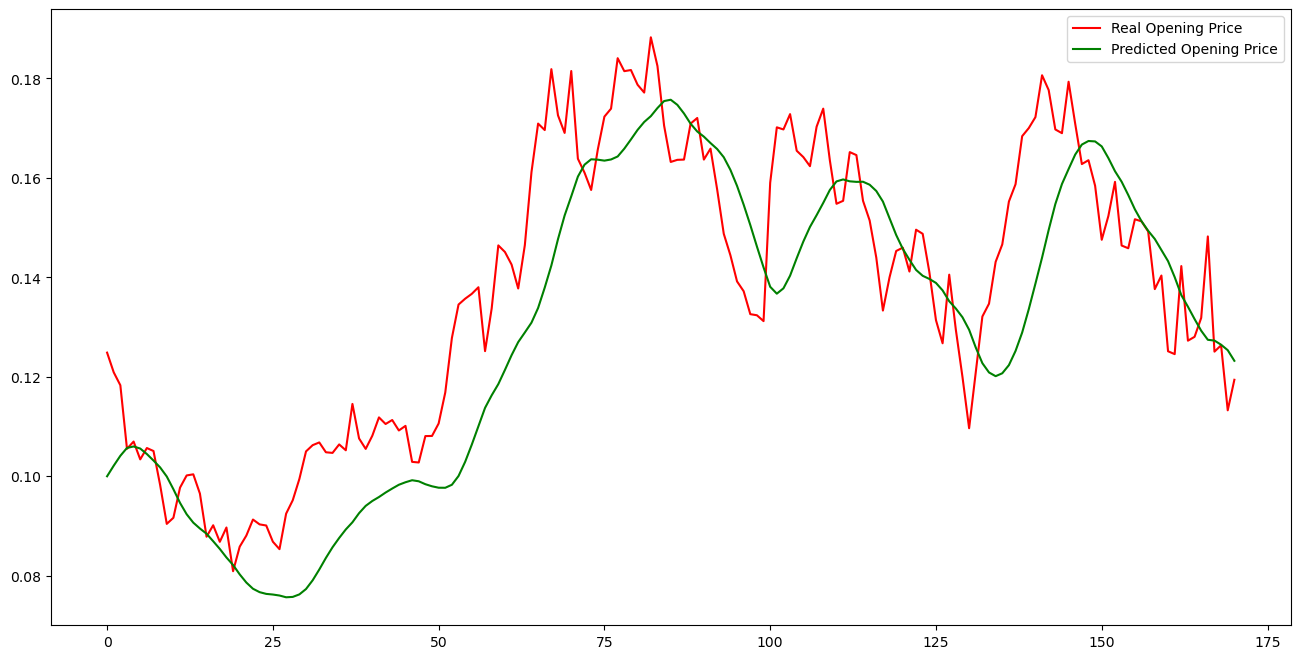

In [36]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Opening Price')
plt.plot(y_pred, color='green', label = 'Predicted Opening Price')
plt.legend(loc='best')